# The Single-Cell Spatial Transcriptomics Analysis (ScSTA) Cookbook

Presented by:

```
Arun Das
Postdoctoral Associate
Hillman Cancer Center
University of Pittsburgh Medical Center
```

First, to get ourselves familiarized with the various modules in our ScSTA cookbook, we will explore the spatial data analysis related to this publication below:

<img src="tutorial_data/covid_data/paper_title.png" alt="Image Title" width="900![paper_title.png]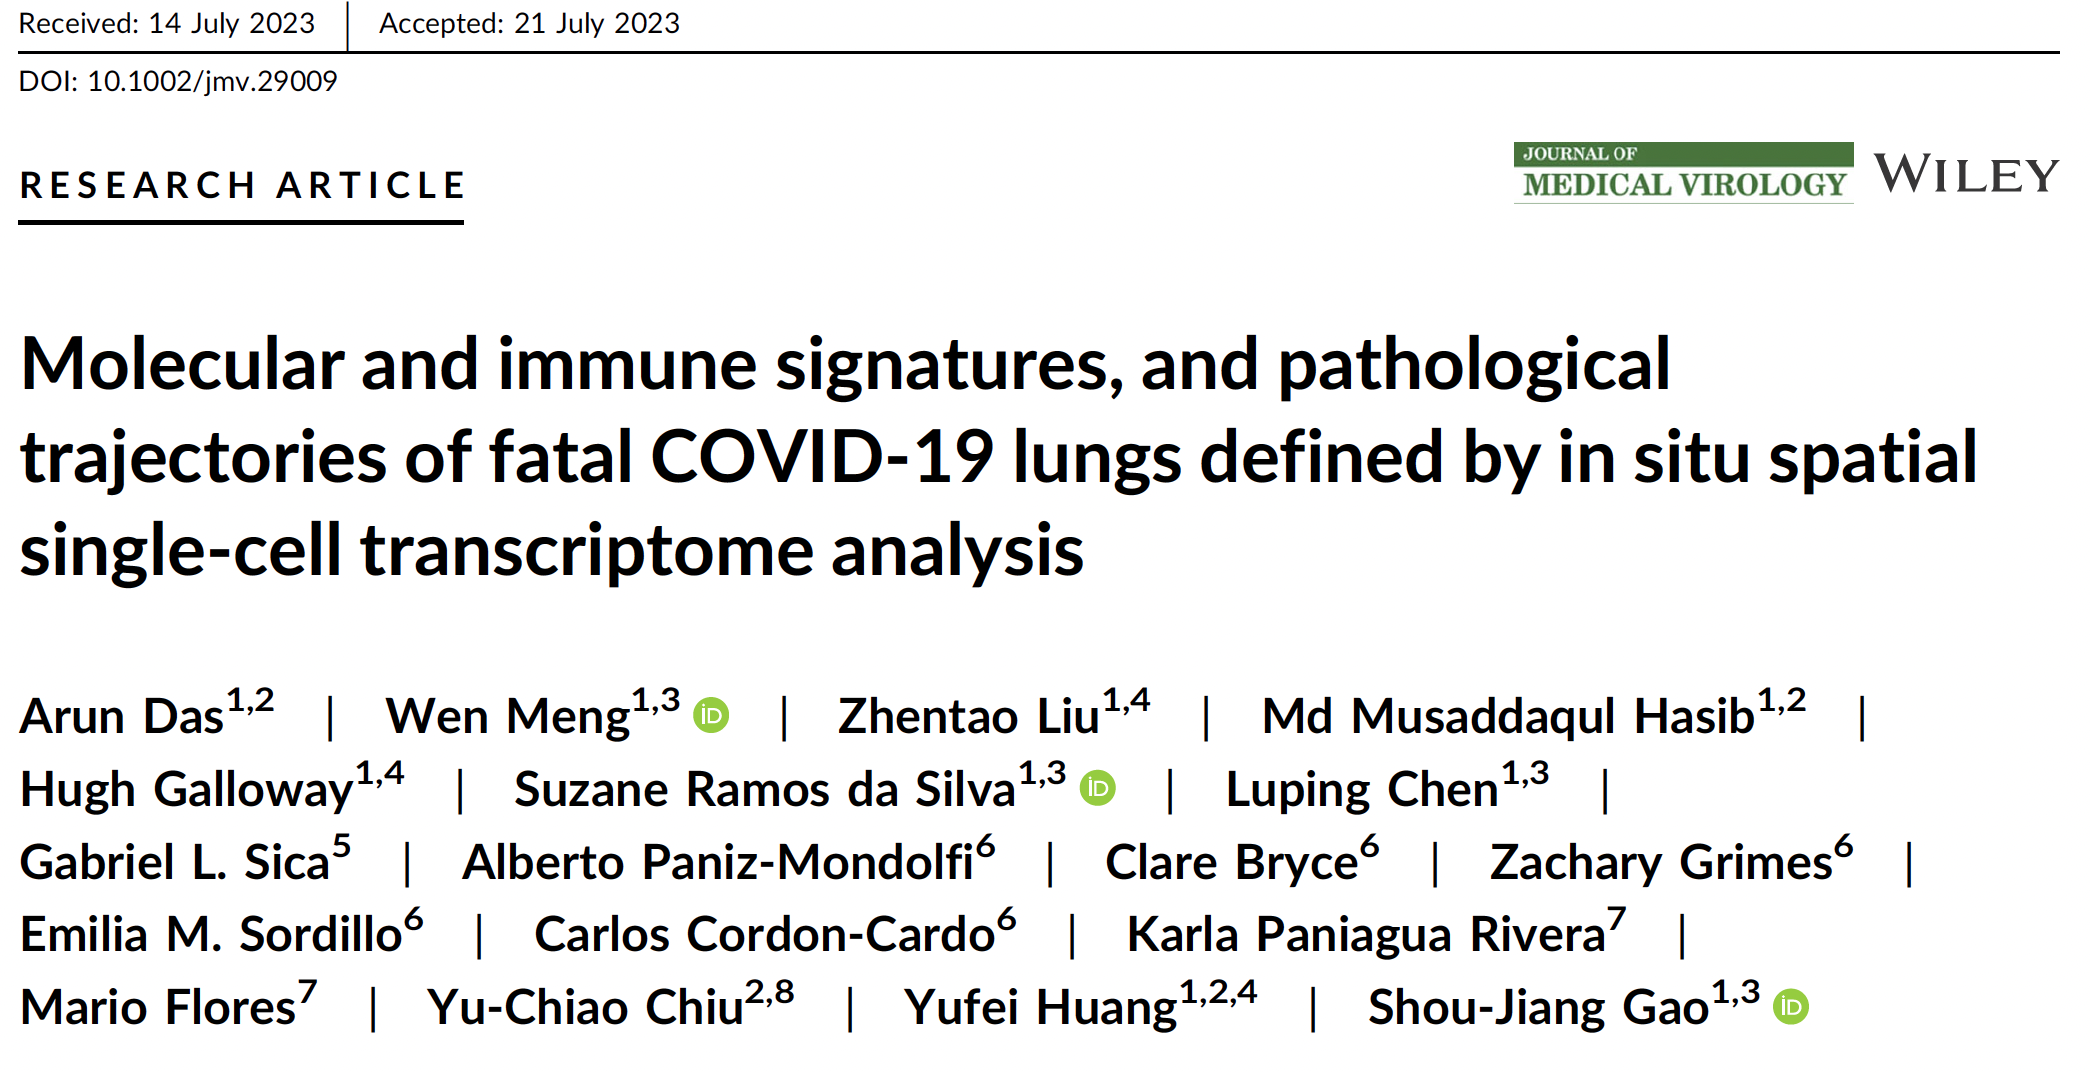">


> How to cite this article: *Das A, Meng W, Liu Z, et al. Molecular and immune signatures, and pathological trajectories of fatal COVID‐19 lungs defined by in situ spatial single‐cell transcriptome analysis. J Med Virol. 2023;95:e29009. doi:10.1002/jmv.29009*

> All published dataset and code can be accessed here: https://zenodo.org/records/7636104

<img src="tutorial_data/spatial_pipeline.png" alt="Image Title" width="900![paper_title.png]">


## Import packages

In [ ]:
%matplotlib inline
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

import os
import sys

from datetime import datetime
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import seaborn as sns
import statsmodels
from matplotlib.collections import LineCollection
from scipy.stats import mannwhitneyu
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity, KNeighborsClassifier, NearestNeighbors
from statsmodels.stats import multitest

import matplotlib.cm as cm
import pathlib
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scanpy as sc

import geopandas as gpd
import esda
import libpysal
import matplotlib.pyplot as plt
from splot.esda import plot_local_autocorrelation

from splot._viz_utils import mask_local_auto, moran_hot_cold_spots, splot_colors
from matplotlib import colors

from IPython.display import Markdown, display

In [ ]:
color_dict = {'Alveolar cells': '#1f77b4',
 'B cells': '#aec7e8',
 'Basal cells': '#ff7f0e',
 'Brush cells': '#ffbb78',
 'Ciliated cells': '#2ca02c',
 'Dendritic cells': '#98df8a',
 'Epithelial cells': '#d62728',
 'Erythrocyte': '#ff9896',
 'Fibroblasts': '#9467bd',
 'Granulocytes': '#c5b0d5',
 'Ionocytes': '#8c564b',
 'Lymphatic endothelial cells': '#c49c94',
 'Macrophages and monocytes': '#e377c2',
 'Mesothelial cells': '#f7b6d2',
 'NK cells': '#7f7f7f',
 'Smooth muscle cells': '#c7c7c7',
 'T cells': '#bcbd22',
 'Vascular endothelial cells': '#dbdb8d'}

## Define some helper functions

In [ ]:
def scatter_df(df, x='x', y='y', c='k', s=[1], figsize=(14,14), cmap=None, 
               dpi = 140, show_axis=False, ax=None, title=None, marker='o', alpha=1.0, label="",
              flip_y=False, flip_x=False, hue=None, vmin=None, vmax=None):

    """
    Scatter plot function to visualize DataFrame data.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        x (str): The column name for the x-axis data.
        y (str): The column name for the y-axis data.
        c (str or array-like): Color for markers, or sequence of colors.
        s (float or array-like): Size of markers.
        figsize (tuple): Figure size (width, height) in inches.
        cmap (Colormap, optional): Colormap for mapping scalar data to colors.
        dpi (int): Dots per inch for the figure resolution.
        show_axis (bool): Whether to display axis or not.
        ax (Axes, optional): Matplotlib Axes instance to plot on.
        title (str): Title for the plot.
        marker (str): Marker style for scatter plot.
        alpha (float): Alpha value for markers.
        label (str): Label for the plot.
        flip_y (bool): Whether to flip the y-axis.
        flip_x (bool): Whether to flip the x-axis.
        hue (str): Variable in DataFrame to map plot aspects to different colors.
        vmin (float): Minimum value to plot.
        vmax (float): Maximum value to plot.

    Returns:
        ax (Axes): Matplotlib Axes with the scatter plot.

    """
    
    dfc = df.copy()
        
    with mpl.rc_context({'figure.dpi':dpi, 'savefig.dpi':dpi, "figure.figsize":figsize}):
        
        if not ax:
            f, ax = plt.subplots(figsize=figsize)

        if flip_y:
            dfc[y] = -dfc[y]

        if flip_x:
            dfc[x] = -dfc[x]
            
        if hue:
            ax.scatter(dfc[x].to_numpy(), dfc[y].to_numpy(), c=dfc[hue], s=s, cmap=cmap, marker=marker, alpha=alpha, label=label, vmin=None, vmax=None)
        else:
            ax.scatter(dfc[x].to_numpy(), dfc[y].to_numpy(), c=c, s=s, cmap=cmap, marker=marker, alpha=alpha, label=label, vmin=None, vmax=None)
        
        if not show_axis:
            plt.axis('off')
        if title:
            plt.title(title)

    return ax

def color_palette(color_palette, sep='   \n   ', width=6):
    display(Markdown(sep.join(
        f'<span style="color: {color_palette[ctype]}">{chr(9608)*width} <span style="font-family: monospace"><span style="color: black">{ctype}</span></span></span>'
        for ctype in color_palette.keys()
    )))

# Load the dataset

## Download the dataset from OneDrive

## Load the dataset with Pandas

In [ ]:
df = pd.read_csv('tutorial_data/covid_data/COVID-19-tissue-1-2C.csv')

In [ ]:
df.columns

## Load the list of genes

In [ ]:
gene_list = pd.read_csv('tutorial_data/covid_data/gene_list_covid.txt', header=None)
gene_list = gene_list.iloc[0].to_list()

In [ ]:
len(gene_list)

## Subset the dataset for this analysis

In [ ]:
df = df[['x', 'y', 'cell_type', 'infection'] + gene_list]

In [ ]:
df

# Let's explore the dataset together!

In [ ]:
ax = scatter_df(df, flip_y = True, figsize=(7,7), dpi=100, s=1, show_axis=True)

In [ ]:
ax = scatter_df(df, flip_y = True, figsize=(17,17), dpi=100, s=1, show_axis=True)

## Percentage of cell types

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=True)

# Plot for adata_HIHD
df['cell_type'].value_counts(normalize=True).plot(kind='bar', ax=ax)
ax.set_title('Cell Type Percentages in Sample 1-2C')
ax.set_ylabel('Normalized Count')  # Assuming you want a shared y-axis label
ax.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=True)
df_inf = df.query("infection == 'Yes'")
# Plot for adata_HIHD
df_inf['cell_type'].value_counts(normalize=True).plot(kind='bar', ax=ax)
ax.set_title('Infected Cell Type Percentages in Sample 1-2C')
ax.set_ylabel('Normalized Count')  # Assuming you want a shared y-axis label
ax.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
df.cell_type.unique(), len(df.cell_type.unique())

# Spatial Maps of Cell Types

In [ ]:
celltype_list = df.cell_type.unique()
celltype_list = sorted(celltype_list)

cell_type = 'Alveolar cells'
cells = df.query(f"cell_type in ['{cell_type}']")
ax = scatter_df(cells, figsize=(7,7), c=color_dict[cell_type], show_axis=False, s=1, title=f"{cell_type}", flip_y=True)
plt.show()


In [ ]:
celltype_list = df.cell_type.unique()
celltype_list = sorted(celltype_list)

cell_type = 'Fibroblasts'
cells = df.query(f"cell_type in ['{cell_type}']")
ax = scatter_df(cells, figsize=(7,7), c=color_dict[cell_type], show_axis=False, s=1, title=f"{cell_type}", flip_y=True)
plt.show()


In [ ]:
color_palette(color_dict)

## ROI-based approach

In [ ]:
def select_region_of_interest(df, x_min, x_max, y_min, y_max):
    """
    Selects a specific region-of-interest from the DataFrame based on x and y coordinates.

    Parameters:
        df (DataFrame): The DataFrame containing columns 'x' and 'y' indicating locations of cells.
        x_min (int): The minimum x-coordinate of the region-of-interest.
        x_max (int): The maximum x-coordinate of the region-of-interest.
        y_min (int): The minimum y-coordinate of the region-of-interest.
        y_max (int): The maximum y-coordinate of the region-of-interest.

    Returns:
        DataFrame: The DataFrame containing rows corresponding to the region-of-interest.
    """
    roi_df = df[(df['x'] >= x_min) & (df['x'] <= x_max) & (df['y'] >= y_min) & (df['y'] <= y_max)]
    return roi_df

In [ ]:
df_roi = select_region_of_interest(df, 25000, 30000, 35000, 42000)
ax = scatter_df(df_roi, flip_y = True, figsize=(7,7), dpi=100, s=5, 
                c=[color_dict[col] for col in df_roi.cell_type], show_axis=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=True)

# Plot for adata_HIHD
df_roi['cell_type'].value_counts(normalize=True).plot(kind='bar', ax=ax)
ax.set_title('Cell Type Percentages ROI')
ax.set_ylabel('Normalized Count')  # Assuming you want a shared y-axis label
ax.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
df

# Spatial Density Analysis

In [ ]:
def spatial_neighborhood_density(cell_locations_df, x='x', y='y', radius = 200.0, leafsize=5000, return_results=True):
    """
    This function calculates the density of individual cells in the spatial dataset and optionally returns the density vector [:return(neighbors, frequency, ax)]. **The function is not optimized for performance.
    """
    tree = spatial.KDTree(cell_locations_df[[x,y]].to_numpy(), leafsize=leafsize)
    neighbors = tree.query_ball_tree(tree, radius)
    frequency = np.array([len(i) for i in neighbors])
    
    if return_results:
            return(neighbors, frequency)

In [ ]:
(neighbors, frequency) = spatial_neighborhood_density(df, x='x', y='y', radius=200)

In [ ]:
df['cell_density'] = frequency

In [ ]:
ax = scatter_df(df, hue='cell_density', flip_y=True, cmap='viridis', figsize=(7,7), s=1, dpi=100)

In [ ]:
ax = scatter_df(df, hue='cell_density', flip_y=True, cmap='Reds', figsize=(7,7), s=1, dpi=100)

# Spatial Neighborhood Cell Type Composition (NCTC) analysis

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from datetime import datetime

def calculate_neighborhood_cell_composition(df, n_neighbors=200):
    """
    This function calculates the composition of cell types in the neighborhoods 
    of each cell in a given DataFrame.
    
    Parameters:
    - df: DataFrame containing cell data, including x and y coordinates and cell types.
    - n_neighbors: Number of nearest neighbors to consider for each cell. Default is 200.
    
    Returns:
    - df: DataFrame with added columns representing the composition of cell types 
          in the neighborhoods of each cell.
    """

    # Extracting coordinates and cell types from the DataFrame
    coords = df[['x', 'y']].values
    cell_types = df.cell_type.values
    
    # Obtaining unique cell types and sorting them
    unique_cell_types = sorted(df.cell_type.unique())

    # Initializing a NearestNeighbors object and fitting it to the data
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(coords)

    # Finding the indices of nearest neighbors for each point
    _, neighbors_indices = neigh.kneighbors(coords)

    # Mapping cell types to indices for faster processing
    cell_type_to_index = {cell_type: i for i, cell_type in enumerate(unique_cell_types)}
    cell_type_indices = np.vectorize(cell_type_to_index.get)(cell_types)

    # Initializing an array to hold the counts of cell types in neighborhoods
    cell_composition_counts = np.zeros((len(df), len(unique_cell_types)))

    # Printing progress information
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Calculating Neighborhood Cell Composition")

    # Counting the occurrences of each cell type in the neighborhoods
    for i, neighbors in enumerate(neighbors_indices):
        # Updating progress every 30000 iterations
        if i % 30000 == 0:
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Processing cell ID: {i}")
        neighbor_types = cell_type_indices[neighbors]
        for neighbor_type in neighbor_types:
            cell_composition_counts[i, neighbor_type] += 1

    # Creating a DataFrame from the counts
    cell_composition_df = pd.DataFrame(cell_composition_counts, columns=[f'n_{ct}' for ct in unique_cell_types])

    # Joining the new DataFrame with the original one
    df = df.join(cell_composition_df)

    # Printing completion message
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Completed Neighborhood Cell Composition")

    return df


In [ ]:
try:
    df.drop(columns=['n_Alveolar cells', 'n_B cells', 'n_Basal cells', 'n_Brush cells', 'n_Ciliated cells', 'n_Dendritic cells',
           'n_Epithelial cells', 'n_Erythrocyte', 'n_Fibroblasts', 'n_Granulocytes',
           'n_Ionocytes', 'n_Lymphatic endothelial cells', 'n_Macrophages and monocytes', 'n_Mesothelial cells', 'n_NK cells',
           'n_Smooth muscle cells', 'n_T cells', 'n_Vascular endothelial cells'], inplace=True)
except:
    pass


df = calculate_neighborhood_cell_composition(df, n_neighbors=200)

In [ ]:
cell_type = 'Fibroblasts'
hue = 'n_' + cell_type
ax = scatter_df(df, figsize=(7,7), hue=hue, flip_y=True, s=1, title=f"{cell_type}", dpi=100)
plt.show()

In [ ]:
cell_type = 'Alveolar cells'
hue = 'n_' + cell_type
ax = scatter_df(df, figsize=(7,7), hue=hue, flip_y=True, s=1, title=f"{cell_type}", dpi=100)
plt.show()


# Pathology or condition related analysis

## Spatial infection patterns

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from datetime import datetime

radius = 1000  # Define the radius that is appropriate for your dataset

# Assuming 'df' is your DataFrame and it includes 'x', 'y' for coordinates, and 'infection' as strings "Yes" and "No"

def count_infected_neighbors_within_radius(df, radius):
    """
    Counts the number of infected neighbors within a specified radius for each cell in a DataFrame.
    
    Parameters:
    - df: DataFrame containing 'x', 'y' coordinates and 'infection' status ("Yes" or "No").
    - radius: The radius within which to count infected neighbors.
    
    The function modifies the input DataFrame in place by adding a column 'n_infected_neighbors'.
    """
    # Ensure 'infection' column exists
    if 'infection' not in df.columns:
        raise ValueError("DataFrame must include an 'infection' column with values 'Yes' or 'No'.")

    # Prepare the coordinates
    coords = df[['x', 'y']].values

    # Convert "Yes"/"No" in the 'infection' column to 1/0
    infection_status = np.where(df['infection'] == "Yes", 1, 0)

    # Create the NearestNeighbors model with radius-based approach
    neigh = NearestNeighbors(radius=radius)
    neigh.fit(coords)

    # Find neighbors within the specified radius for each point
    # The method returns a list of arrays, where each array contains the indices of neighbors within the radius
    neighbors_indices = neigh.radius_neighbors(coords, return_distance=False)

    # Initialize an array to store the count of infected neighbors for each cell
    infected_neighbor_counts = np.zeros(len(df), dtype=int)

    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Calculating Number of Infected Neighbors")

    # Count the number of infected neighbors for each cell
    for i, neighbors in enumerate(neighbors_indices):
        # Sum the infection status of neighbors to get the count of infected ones
        infected_neighbor_counts[i] = infection_status[list(neighbors)].sum()

        # Update progress for every 30000 cells processed
        if i % 30000 == 0:
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Processing cell ID: {i}")

    # Add the count of infected neighbors as a new column in the DataFrame
    df['n_infected_neighbors'] = infected_neighbor_counts

    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Completed Counting Infected Neighbors")
    
    return df

In [ ]:
df = count_infected_neighbors_within_radius(df, radius=1000)

In [ ]:
scatter_df(df, hue='n_infected_neighbors', flip_y=True, figsize=(7,7), dpi=100, cmap='rainbow')

# Spatial Correlation Analysis

In [ ]:
def lisa_cluster(
    moran_loc, gdf, p=0.05, ax=None, legend=True, legend_kwds=None, two_category=True, **kwargs
):
    """
    Create a LISA Cluster map. Based on https://splot.readthedocs.io/en/latest/generated/splot.esda.lisa_cluster.html

    Parameters
    ----------
    moran_loc : esda.moran.Moran_Local or Moran_Local_BV instance
        Values of Moran's Local Autocorrelation Statistic
    gdf : geopandas dataframe instance
        The Dataframe containing information to plot. Note that `gdf` will be
        modified, so calling functions should use a copy of the user
        provided `gdf`. (either using gdf.assign() or gdf.copy())
    p : float, optional
        The p-value threshold for significance. Points will
        be colored by significance.
    ax : matplotlib Axes instance, optional
        Axes in which to plot the figure in multiple Axes layout.
        Default = None
    legend : boolean, optional
        If True, legend for maps will be depicted. Default = True
    legend_kwds : dict, optional
        Dictionary to control legend formatting options. Example:
        ``legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}``
        Default = None
    **kwargs : keyword arguments, optional
        Keywords designing and passed to geopandas.GeoDataFrame.plot().

    Returns
    -------
    fig : matplotlip Figure instance
        Figure of LISA cluster map
    ax : matplotlib Axes instance
        Axes in which the figure is plotted

    Examples
    --------
    Imports

    >>> import matplotlib.pyplot as plt
    >>> from libpysal.weights.contiguity import Queen
    >>> from libpysal import examples
    >>> import geopandas as gpd
    >>> from esda.moran import Moran_Local
    >>> from splot.esda import lisa_cluster

    Data preparation and statistical analysis

    >>> guerry = examples.load_example('Guerry')
    >>> link_to_data = guerry.get_path('guerry.shp')
    >>> gdf = gpd.read_file(link_to_data)
    >>> y = gdf['Donatns'].values
    >>> w = Queen.from_dataframe(gdf)
    >>> w.transform = 'r'
    >>> moran_loc = Moran_Local(y, w)

    Plotting

    >>> fig = lisa_cluster(moran_loc, gdf)
    >>> plt.show()

    """
    # retrieve colors5 and labels from mask_local_auto
    _, colors5, _, labels = mask_local_auto(moran_loc, p=p)
    
    if two_category:
        
        replace_labels = {'ns':'ns',
                 'LL':'LL',
                  'LH':'ns',
                 'HL':'ns',
                  'HH':'HH'
                 }
        labels = [replace_labels[each] for each in labels]
        colors5.pop(1)
        
    # define ListedColormap
    hmap = colors.ListedColormap(colors5)

    if ax is None:
        figsize = kwargs.pop("figsize", None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    # check for Polygon, else no edgecolor
    if gdf.geom_type.isin(["Polygon", "MultiPolygon"]).any():
        gdf.assign(cl=labels).plot(
            column="cl",
            categorical=True,
            k=2,
            cmap=hmap,
            linewidth=0.1,
            ax=ax,
            edgecolor="white",
            legend=legend,
            legend_kwds=legend_kwds,
            **kwargs
        )
    else:
        gdf.assign(cl=labels).plot(
            column="cl",
            categorical=True,
            k=2,
            cmap=hmap,
            linewidth=1.5,
            ax=ax,
            legend=legend,
            legend_kwds=legend_kwds,
            **kwargs
        )
    ax.set_axis_off()
    ax.set_aspect("equal")
    return fig, ax

## Spatial autocorrelation of cell density

In [ ]:
# Create a GeoDataFrame from the DataFrame using x and y columns
geometry = gpd.points_from_xy(df['x'], df['y'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Calculate queen contiguity weights
w = libpysal.weights.Queen.from_dataframe(gdf)

# Convert the infection column to a numpy array
study_var = np.array(df["cell_density"])

# Perform LISA analysis
lisa = esda.Moran_Local(study_var, w)

ax = lisa_cluster(
    lisa,
    gdf,
    p=0.05,
    legend=True,
    legend_kwds={"loc": "upper left", "bbox_to_anchor": (0.92, 1.05)},
    s=1,
    figsize=(17,17),
    two_category=False
)

ax[1].invert_yaxis()
plt.show()

In [ ]:
# Extracting the LISA DataFrame
lisa_df = pd.DataFrame({
    'Spatial Unit': range(len(study_var)),
    'Moran_Local': lisa.Is,
    'p-value': lisa.p_sim
})

lisa_df['Quadrant'] = lisa.q

lisa_mapping = {'HH': 1, 'LH': 2, 'LL': 3, 'HL': 4}

lisa_df

In [ ]:
lisa_df.Quadrant.value_counts()

In [ ]:
df['cell_density_moran_clusters'] = lisa_df['Quadrant']

In [ ]:
HH_cells = lisa_df.query(f"Quadrant == {lisa_mapping['HH']}")['Spatial Unit']
df_HH = df.iloc[HH_cells]

ax = scatter_df(df, c='gray', figsize=(17,17), dpi=100, flip_y=True)
ax = scatter_df(df_HH, c='r', figsize=(17,17), dpi=100, ax=ax, flip_y=True)


## Spatial autocorrelation of infected neighbors

In [ ]:
# Create a GeoDataFrame from the DataFrame using x and y columns
geometry = gpd.points_from_xy(df['x'], df['y'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Calculate queen contiguity weights
w = libpysal.weights.Queen.from_dataframe(gdf)

# Convert the infection column to a numpy array
study_var = np.array(df["n_infected_neighbors"])

# Perform LISA analysis
lisa = esda.Moran_Local(study_var, w)

ax = lisa_cluster(
    lisa,
    gdf,
    p=0.05,
    legend=True,
    legend_kwds={"loc": "upper left", "bbox_to_anchor": (0.92, 1.05)},
    s=1,
    figsize=(17,17),
    two_category=False
)

# Extracting the LISA DataFrame
lisa_df = pd.DataFrame({
    'Spatial Unit': range(len(study_var)),
    'Moran_Local': lisa.Is,
    'p-value': lisa.p_sim
})

lisa_df['Quadrant'] = lisa.q

lisa_mapping = {'HH': 1, 'LH': 2, 'LL': 3, 'HL': 4}

df['n_infected_neighbors_moran_clusters'] = lisa_df['Quadrant']

ax[1].invert_yaxis()
plt.show()

In [ ]:
lisa_df

In [ ]:
lisa_df.Quadrant.value_counts()

# Differential Experssion Analysis

In [ ]:
from anndata import AnnData

In [ ]:
adata = AnnData(X=df[gene_list], obs=df[df.columns[~df.columns.isin(gene_list + ['geometry'])]])

In [ ]:
adata.obsm['spatial'] = df[['x', 'y']].to_numpy()

In [ ]:
adata.var_names = gene_list

In [ ]:
adata

In [ ]:
adata.obs

## DE of HIHD and LILD regions

### Subset the regions

In [ ]:
# Create subsets for HH regions in both conditions
adata_HIHD = adata[adata.obs.query("n_infected_neighbors_moran_clusters==1 and cell_density_moran_clusters==1").index].copy()
adata_LILD = adata[adata.obs.query("n_infected_neighbors_moran_clusters==3 and cell_density_moran_clusters==3").index].copy()

In [ ]:
adata_HIHD

In [ ]:
adata_LILD

### Cell type percentages

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for adata_HIHD
adata_HIHD.obs['cell_type'].value_counts(normalize=True).plot(kind='bar', ax=axs[0])
axs[0].set_title('High Infection and High Density Cells')
axs[0].set_ylabel('Normalized Count')  # Assuming you want a shared y-axis label
axs[0].grid()

# Plot for adata_LILD
adata_LILD.obs['cell_type'].value_counts(normalize=True).plot(kind='bar', ax=axs[1])
axs[1].set_title('Low Infection and Low Density Cells')
axs[1].grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Assign groups and combined the regions

In [ ]:
# Add a new categorical variable to distinguish the subsets
adata_HIHD.obs['group'] = 'HIHD'
adata_LILD.obs['group'] = 'LILD'

# Concatenate the subsets into a single AnnData object
adata_combined = adata_HIHD.concatenate(adata_LILD, batch_key='group_comparison', batch_categories=['HIHD', 'LILD'])

### Visualize the regions

In [ ]:
ax = scatter_df(df, c='gray', figsize=(10,10), dpi=100, flip_y=True)
ax = scatter_df(adata_HIHD.obs, c='r', figsize=(10,10), dpi=100, ax=ax, flip_y=True)
ax = scatter_df(adata_LILD.obs, c='b', figsize=(10,10), dpi=100, ax=ax, flip_y=True)

### Execute DE

In [ ]:
#scanpy

In [ ]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(adata_combined, groupby='group_comparison', groups=['HIHD'],  method='t-test')

### Plot DE results

In [ ]:
# Plot the top differentially expressed genes
sc.pl.rank_genes_groups(adata_combined, n_genes=25, sharey=False)  # Adjust n_genes as needed